# Importing packages 

In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import TFDistilBertModel, DistilBertTokenizer, DistilBertConfig,  DistilBertForSequenceClassification, TFDistilBertForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joostfranssen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pre-processing of the dataset

In [3]:
# Functions to preprocess the data
# Stopwords, shortwords and special characters are removed 
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list = stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = clean_stopwords_shortwords(w)
    w = re.sub(r'@\w+', '',w)
    return w

In [4]:
# Load the training and test dataset
TRAIN_FILE_PATH = '/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2A/Dl/Lab 2/train.csv'
TEST_FILE_PATH = '/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2A/Dl/Lab 2/test.csv'

train_data = pd.read_csv(TRAIN_FILE_PATH)
test_data = pd.read_csv(TEST_FILE_PATH)

In [5]:
# Concatenate the title and description and preprocess the sentences, and reduce all classes by one 
train_data['Title'] = train_data['Title'].map(preprocess_sentence)
train_data['Description'] = train_data['Description'].map(preprocess_sentence)

X_train = train_data['Title'] + " " + train_data['Description']
y_train = train_data['Class Index'].apply(lambda x: x-1).values 

test_data['Title'] = test_data['Title'].map(preprocess_sentence)
test_data['Description'] = test_data['Description'].map(preprocess_sentence)

X_test = test_data['Title'] + " " + test_data['Description']
y_test = test_data['Class Index'].apply(lambda x: x-1).values

len(X_train),len(y_train)

(120000, 120000)

In [6]:
longest_string = max(X_train, key=lambda x: len(x.split()))
print(longest_string)
print("\n")

n_words = len(X_train[0].split())
print(n_words)

biotech baggers yesterday biotech winners lead today top performers meta name keywords content charly travers rule breakers biotech eln elan imclone imcl sepracor sepr meta name tickers content nasdaq biib nasdaq imcl nasdaq sepr nyse eln nyse wye nyse bmy biib imcl sepr eln wye bmy meta name summary content meta name author content charly travers meta name date content meta name language content meta name story uid content usmf content datasource commentary centerized commentary xml meta name expiration content date months meta name articletype content investing meta name contenttype content title fool com biotech baggers commentary october title script language javascript


17


In [7]:
import statistics
from statistics import mean, stdev

24.777708333333333
6.918156805757137


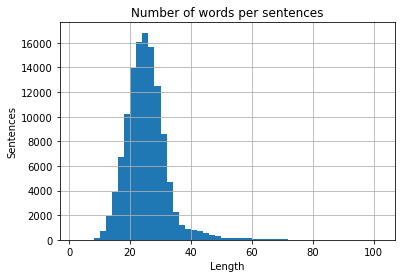

In [11]:
# Statistics about the sentences in the training data set
length = [] 

for i in range(len(X_train)):
    length.append(len(X_train[i].split()))

avg = statistics.mean(length)
std = statistics.stdev(length)


pd.Series(length).hist(bins = 50)
plt.title('Number of words per sentences')
plt.xlabel('Length')
plt.ylabel('Sentences')

print(avg)
print(std)

In [9]:
max_len = round(avg)
print(max_len)

num_classes = 4

25


# Tokenize Data

In [10]:
# Load tokinezer 
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [11]:
# Tokenize training data
input_ids = []
attention_masks = []

for sent in X_train:
    dbert_inps = dbert_tokenizer.encode_plus(sent,add_special_tokens = True, max_length = max_len, padding = 'max_length', return_attention_mask = True, truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

train_input_ids = np.asarray(input_ids)
train_attention_masks = np.array(attention_masks)
y_train = np.array(y_train)

In [12]:
# Tokenize test data
test_input_ids = []
test_attention_masks = []

for sent in X_test:
    dbert_inps = dbert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length = max_len, padding = 'max_length', return_attention_mask = True,truncation=True)
    test_input_ids.append(dbert_inps['input_ids'])
    test_attention_masks.append(dbert_inps['attention_mask'])

test_input_ids = np.asarray(test_input_ids)
test_attention_masks = np.array(test_attention_masks)
y_test = np.array(y_test)

### Example of tokenization of the random sentence

In [13]:
X_train[12]

'non opec nations output purnomo jakarta reuters non opec oil exporters consider increasing output cool record crude prices opec president purnomo yusgiantoro said sunday'

In [14]:
dbert_tokenizer.tokenize(X_train[12])

['non',
 'op',
 '##ec',
 'nations',
 'output',
 'pu',
 '##rno',
 '##mo',
 'jakarta',
 'reuters',
 'non',
 'op',
 '##ec',
 'oil',
 'export',
 '##ers',
 'consider',
 'increasing',
 'output',
 'cool',
 'record',
 'crude',
 'prices',
 'op',
 '##ec',
 'president',
 'pu',
 '##rno',
 '##mo',
 'yu',
 '##sg',
 '##ian',
 '##tor',
 '##o',
 'said',
 'sunday']

In [15]:
dbert_inp=dbert_tokenizer.encode_plus(X_train[12],add_special_tokens=True, max_length=max_len,pad_to_max_length = True,truncation=True)

/Users/joostfranssen/tensorflow-test/env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
dbert_inp['input_ids']

[101,
 2512,
 6728,
 8586,
 3741,
 6434,
 16405,
 19139,
 5302,
 14426,
 26665,
 2512,
 6728,
 8586,
 3514,
 9167,
 2545,
 5136,
 4852,
 6434,
 4658,
 2501,
 13587,
 7597,
 102]

In [17]:
dbert_inp['attention_mask']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Optimize pretrained distilbert model

In [18]:
# Function to create keras model with distilbert model, to train and generate output
def create_model_pretrained():
    inps = Input(shape = (max_len,), dtype='int64')
    masks = Input(shape = (max_len,), dtype='int64')
    dbert_model_pretrained = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
    dbert_layer = dbert_model_pretrained(inps, attention_mask=masks)[0][:,0,:]
    pred = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)) (dbert_layer)   #(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    return model

In [19]:
pretrained_model = create_model_pretrained()

Metal device set to: Apple M1 Pro


2022-03-28 18:25:19.828364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-28 18:25:19.828656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-28 18:25:19.849641: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task 

In [28]:
# Accuracy of pretrained model, before any further training
preds0 = pretrained_model.predict([test_input_ids, test_attention_masks], batch_size=32)
pred_labels0 = np.argmax(preds0, axis=1)
acc_pretrained0 = accuracy_score(y_test, pred_labels0)
print(f'Accuracy pretrained model before optimizing: {acc_pretrained0}')

2022-03-28 16:00:45.792005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy pretrained model before optimizing: 0.24921052631578947


In [28]:
# Grid search to find best optimizer

train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(train_input_ids, y_train, train_attention_masks, test_size=0.2, random_state=0)
print('Train shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

lr = 1e-5
optimizers = [tf.keras.optimizers.Adam(learning_rate=lr), tf.keras.optimizers.SGD(learning_rate=lr), tf.keras.optimizers.RMSprop(learning_rate=lr)]
optimizer_names = ['adam', 'sgd', 'rmsprop']

models = []
val_accs = []
losses = []
for optimizer, optimizer_name in zip(optimizers, optimizer_names):
    print('Training for optimizer: ' + optimizer_name)
    log_dir='dbert_model_pretrained_' + optimizer_name
    model_save_path='./dbert_model_pretrained_' + optimizer_name + '.h5'
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
    
    pretrained_model = create_model_pretrained()
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    pretrained_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    history = pretrained_model.fit([train_inp,train_mask], train_label, batch_size=32, epochs=10, validation_data=([val_inp,val_mask],val_label), callbacks=callbacks)

    models.append((pretrained_model, history))
    val_accs.append(history.history['val_accuracy'])
    losses.append(history.history['val_loss'])

print(val_accs)
best_model_pretrained, best_history_pretrained = models[val_accs.index(max(val_accs))]

Train shape (96000, 25) Val input shape (24000, 25)
Train label shape (96000,) Val label shape (24000,)
Train attention mask shape (96000, 25) Val attention mask shape (24000, 25)
Training for optimizer: rmsprop


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10


2022-03-28 18:42:50.390190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.9007

2022-03-28 18:49:52.653609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - 451s 148ms/step - loss: 0.3645 - accuracy: 0.9007 - val_loss: 0.3056 - val_accuracy: 0.9224
Epoch 2/10
3000/3000 [==============================] - 444s 148ms/step - loss: 0.2818 - accuracy: 0.9271 - val_loss: 0.2967 - val_accuracy: 0.9236
Epoch 3/10
3000/3000 [==============================] - 442s 147ms/step - loss: 0.2325 - accuracy: 0.9414 - val_loss: 0.2825 - val_accuracy: 0.9252
Epoch 4/10
3000/3000 [==============================] - 443s 148ms/step - loss: 0.1905 - accuracy: 0.9529 - val_loss: 0.3061 - val_accuracy: 0.9269
Epoch 5/10
3000/3000 [==============================] - 444s 148ms/step - loss: 0.1533 - accuracy: 0.9632 - val_loss: 0.3501 - val_accuracy: 0.9266
Epoch 6/10
3000/3000 [==============================] - 443s 148ms/step - loss: 0.1206 - accuracy: 0.9724 - val_loss: 0.3562 - val_accuracy: 0.9220
Epoch 7/10
3000/3000 [==============================] - 442s 147ms/step - loss: 0.0977 - accuracy: 0.9787 - val_loss: 0.418

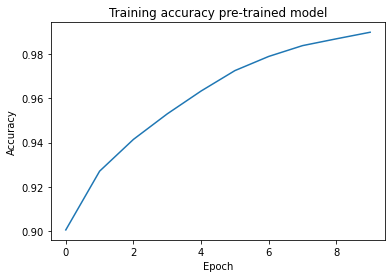

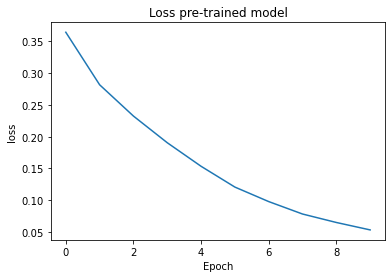

In [29]:
# Plot training accuracy and loss of model with best validation accuracy
plt.plot(best_history_pretrained.history['accuracy'])
plt.title('Training accuracy pre-trained model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(best_history_pretrained.history['loss'])
plt.title('Loss pre-trained model')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [30]:
# Load weights from saved optimized pretrained model
optimized_pretrained_model = create_model_pretrained()
optimized_pretrained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
optimized_pretrained_model.load_weights('./dbert_model_pretrained_rmsprop.h5') 

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# Testing the pre-trained model

In [31]:
# Create predictions using the test data
preds = optimized_pretrained_model.predict([test_input_ids, test_attention_masks], batch_size=32)
pred_labels = np.argmax(preds, axis=1)

2022-03-28 19:58:26.508407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [32]:
acc_pretrained = accuracy_score(y_test, pred_labels)
f1_pretrained = f1_score(y_test, pred_labels, average='macro')
print(f'Accuracy pretrained model after optimizing: {acc_pretrained}')
print(f'F1-score pretrained model after optimizing: {f1_pretrained}')

Accuracy pretrained model after optimizing: 0.9213157894736842
F1-score pretrained model after optimizing: 0.921376774362968


In [33]:
target_names = ['world', 'sports', 'business', 'science']
print('Classification Report:')
print(classification_report(y_test, pred_labels, target_names=target_names)) 

Classification Report:
              precision    recall  f1-score   support

       world       0.94      0.91      0.92      1900
      sports       0.97      0.98      0.97      1900
    business       0.88      0.90      0.89      1900
     science       0.90      0.89      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



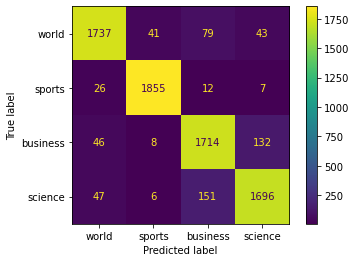

In [34]:
# Confusion matrix
cm_pretrained = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pretrained, display_labels=target_names)
disp.plot()
plt.show()

# Training from scratch


In [35]:
# Function to create keras model with distilbert model, to train and generate output
def create_model_untrained():
    inps = Input(shape = (max_len,), dtype='int64')
    masks = Input(shape = (max_len,), dtype='int64')
    config = DistilBertConfig()
    dbert_model_untrained = TFDistilBertModel(config)
    dbert_layer = dbert_model_untrained(inps, attention_mask=masks)[0][:,0,:]
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)) (dbert_layer)   #(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    return model

In [36]:
scratch_model = create_model_untrained()

In [37]:
# Accuracy of scratch model, before any further training
preds_scratch0 = scratch_model.predict([test_input_ids, test_attention_masks], batch_size=32)
pred_labels_scratch0 = np.argmax(preds_scratch0, axis=1)
acc_pretrained_scratch0 = accuracy_score(y_test, pred_labels_scratch0)
print(f'Accuracy scratch model before training: {acc_pretrained_scratch0}')

2022-03-28 19:59:03.575717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy scratch model before training: 0.25


In [38]:
# Grid search to find best optimizer for the model from scratch

train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(train_input_ids, y_train, train_attention_masks, test_size=0.2, random_state=0)
print('Train shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

lr = 1e-5
optimizers = [tf.keras.optimizers.Adam(learning_rate=lr), tf.keras.optimizers.SGD(learning_rate=lr), tf.keras.optimizers.RMSprop(learning_rate=lr)]
optimizer_names = ['adam', 'sgd', 'rmsprop']

models_scratch = []
val_accs_scratch = []
losses_scratch = []
for optimizer, optimizer_name in zip(optimizers, optimizer_names):
    print('Training for optimizer: ' + optimizer_name)
    log_dir='dbert_model_scratch_' + optimizer_name
    model_save_path='./dbert_scratch_scratch_' + optimizer_name + '.h5'
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
    
    scratch_model = create_model_untrained()
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    scratch_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    history = scratch_model.fit([train_inp,train_mask], train_label, batch_size=32, epochs=10, validation_data=([val_inp,val_mask],val_label), callbacks=callbacks)

    models_scratch.append((scratch_model, history))
    val_accs_scratch.append(history.history['val_accuracy'])
    losses_scratch.append(history.history['val_loss'])

print(val_accs_scratch)
best_model_scratch, best_history_scratch = models_scratch[val_accs_scratch.index(max(val_accs_scratch))]

Train shape (96000, 25) Val input shape (24000, 25)
Train label shape (96000,) Val label shape (24000,)
Train attention mask shape (96000, 25) Val attention mask shape (24000, 25)
Training for optimizer: adam
Epoch 1/10


2022-03-28 19:59:21.987859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.8161

2022-03-28 20:06:20.973639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - 448s 147ms/step - loss: 0.5805 - accuracy: 0.8161 - val_loss: 0.4041 - val_accuracy: 0.8910
Epoch 2/10
3000/3000 [==============================] - 439s 146ms/step - loss: 0.3572 - accuracy: 0.9042 - val_loss: 0.3742 - val_accuracy: 0.8975
Epoch 3/10
3000/3000 [==============================] - 439s 146ms/step - loss: 0.2966 - accuracy: 0.9216 - val_loss: 0.3597 - val_accuracy: 0.9045
Epoch 4/10
3000/3000 [==============================] - 439s 146ms/step - loss: 0.2566 - accuracy: 0.9336 - val_loss: 0.3694 - val_accuracy: 0.9025
Epoch 5/10
3000/3000 [==============================] - 437s 146ms/step - loss: 0.2238 - accuracy: 0.9418 - val_loss: 0.3814 - val_accuracy: 0.8999
Epoch 6/10
3000/3000 [==============================] - 436s 145ms/step - loss: 0.1972 - accuracy: 0.9485 - val_loss: 0.3952 - val_accuracy: 0.8993
Epoch 7/10
3000/3000 [==============================] - 436s 145ms/step - loss: 0.1697 - accuracy: 0.9557 - val_loss: 0.426

2022-03-28 21:12:31.850516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - ETA: 0s - loss: 1.5292 - accuracy: 0.2550

2022-03-28 21:18:02.764186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - 360s 118ms/step - loss: 1.5292 - accuracy: 0.2550 - val_loss: 1.4664 - val_accuracy: 0.2694
Epoch 2/10
3000/3000 [==============================] - 352s 117ms/step - loss: 1.4778 - accuracy: 0.2764 - val_loss: 1.4567 - val_accuracy: 0.2955
Epoch 3/10
3000/3000 [==============================] - 352s 117ms/step - loss: 1.4589 - accuracy: 0.2961 - val_loss: 1.4470 - val_accuracy: 0.3235
Epoch 4/10
3000/3000 [==============================] - 351s 117ms/step - loss: 1.4458 - accuracy: 0.3260 - val_loss: 1.4410 - val_accuracy: 0.3182
Epoch 5/10
3000/3000 [==============================] - 352s 117ms/step - loss: 1.4361 - accuracy: 0.3496 - val_loss: 1.4284 - val_accuracy: 0.3689
Epoch 6/10
3000/3000 [==============================] - 351s 117ms/step - loss: 1.4271 - accuracy: 0.3736 - val_loss: 1.4179 - val_accuracy: 0.4028
Epoch 7/10
3000/3000 [==============================] - 351s 117ms/step - loss: 1.4185 - accuracy: 0.3950 - val_loss: 1.409

2022-03-28 22:11:19.198890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.7798

2022-03-28 22:18:34.844175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3000/3000 [==============================] - 466s 150ms/step - loss: 0.6607 - accuracy: 0.7798 - val_loss: 0.4471 - val_accuracy: 0.8775
Epoch 2/10
3000/3000 [==============================] - 443s 148ms/step - loss: 0.3982 - accuracy: 0.8904 - val_loss: 0.3749 - val_accuracy: 0.8996
Epoch 3/10
3000/3000 [==============================] - 444s 148ms/step - loss: 0.3544 - accuracy: 0.9029 - val_loss: 0.3723 - val_accuracy: 0.9005
Epoch 4/10
3000/3000 [==============================] - 446s 149ms/step - loss: 0.3320 - accuracy: 0.9089 - val_loss: 0.3476 - val_accuracy: 0.9042
Epoch 5/10
3000/3000 [==============================] - 444s 148ms/step - loss: 0.3111 - accuracy: 0.9143 - val_loss: 0.3431 - val_accuracy: 0.9020
Epoch 6/10
3000/3000 [==============================] - 443s 148ms/step - loss: 0.2882 - accuracy: 0.9207 - val_loss: 0.3473 - val_accuracy: 0.9052
Epoch 7/10
3000/3000 [==============================] - 443s 147ms/step - loss: 0.2626 - accuracy: 0.9273 - val_loss: 0.368

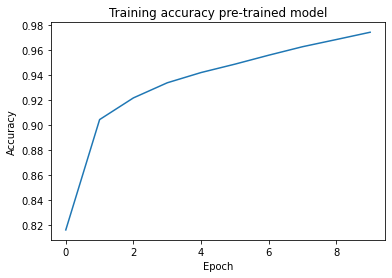

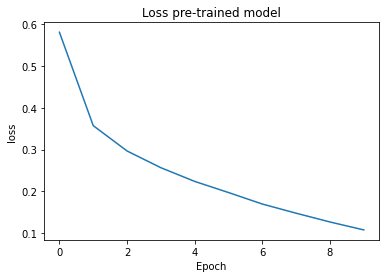

In [39]:
# Plot training accuracy and loss of model with best validation accuracy
plt.plot(best_history_scratch.history['accuracy'])
plt.title('Training accuracy pre-trained model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(best_history_scratch.history['loss'])
plt.title('Loss pre-trained model')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [40]:
# Load weights from saved trained model from scratch
scratch_trained_model = create_model_untrained()
scratch_trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
scratch_trained_model.load_weights('./dbert_scratch_scratch_rmsprop.h5')

# Testing the scratch model

In [41]:
# Create predictions using the test data
preds_scratch = scratch_trained_model.predict([test_input_ids, test_attention_masks], batch_size=32)
pred_labels_scratch = np.argmax(preds_scratch, axis=1)

2022-03-28 23:25:37.056968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [42]:
acc_scratch = accuracy_score(y_test, pred_labels_scratch)
f1_scratch = f1_score(y_test, pred_labels_scratch, average='macro')
print(f'Accuracy scratch model after optimizing: {acc_scratch}')
print(f'F1-score scratch model after optimizing: {f1_scratch}')

Accuracy scratch model after optimizing: 0.9017105263157895
F1-score scratch model after optimizing: 0.9018747415322996


In [43]:
# Classification report
target_names = ['world', 'sports', 'business', 'science']
print('Classification Report:')
print(classification_report(y_test, pred_labels_scratch, target_names=target_names)) 

Classification Report:
              precision    recall  f1-score   support

       world       0.93      0.89      0.91      1900
      sports       0.95      0.96      0.96      1900
    business       0.84      0.89      0.87      1900
     science       0.89      0.87      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



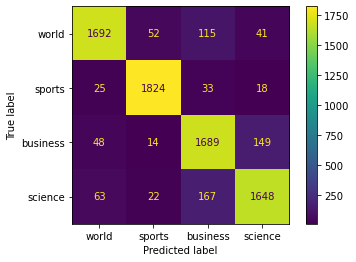

In [44]:
# Confusion matrix
cm_scratch = confusion_matrix(y_test, pred_labels_scratch)
disp_scratch = ConfusionMatrixDisplay(confusion_matrix=cm_scratch, display_labels=target_names)
disp_scratch.plot()
plt.show()